<a href="https://colab.research.google.com/github/Cp557/AstroML-Galaxy-Analysis/blob/main/redshift_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Redshift Regression Model

This script implements a machine learning model to predict galaxy redshifts
using color indices derived from SDSS photometric data. It includes data
preprocessing, exploratory data analysis, model training (Ridge Regression
and XGBoost), hyperparameter tuning, and model evaluation.

Key Features:
- Data loading and preprocessing of SDSS galaxy color data
- Exploratory data analysis with correlation heatmaps and pair plots
- Implementation of Ridge Regression from scratch
- XGBoost model with hyperparameter tuning using GridSearchCV
- Model evaluation and comparison
- Feature importance analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from joblib import dump

In [ ]:
sdss_galaxy_colors_path = '/content/drive/MyDrive/Coding/astronomy_ML/sdss_galaxy_colors.npy' #path to sdss galaxy color data

sdss_data = np.load(sdss_galaxy_colors_path)

sdss = pd.DataFrame(sdss_data)

In [ ]:
# Calculate color indices from magnitudes
sdss['u-g'] = sdss['u'] - sdss['g']
sdss['g-r'] = sdss['g'] - sdss['r']
sdss['r-i'] = sdss['r'] - sdss['i']
sdss['i-z'] = sdss['i'] - sdss['z']
sdss = sdss.drop(columns=['u', 'g', 'r', 'i', 'z', 'redshift_err', 'spec_class'])
sdss = sdss.dropna()
sdss = sdss[['u-g', 'g-r', 'r-i', 'i-z', 'redshift']]

In [ ]:
print('sdss df:')
print('\n' , sdss.info())
print('\n' , sdss.describe())

sdss df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u-g       50000 non-null  float64
 1   g-r       50000 non-null  float64
 2   r-i       50000 non-null  float64
 3   i-z       50000 non-null  float64
 4   redshift  50000 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB

 None

                 u-g           g-r           r-i           i-z      redshift
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean       1.298110      0.651621      0.346665      0.236795      0.290326
std        0.574502      0.304506      0.146466      0.142694      0.539877
min       -2.719890     -0.762260     -5.588950     -2.413520     -0.000513
25%        1.062255      0.451620      0.293937      0.167362      0.064022
50%        1.370010      0.710865      0.392350      0.270130      0.093929
75%        1.766528      0.88

u-g, g-r, r-i, i-z: Color indices, representing differences between magnitudes in different filters. These indices provide information about the color and, therefore, the properties of the galaxies.

redshift: The redshift measures how much the light from a galaxy has been stretched as it moves away from us, shifting towards longer (redder) wavelengths. This shift is an indication of the galaxy's velocity relative to us, which is due to the expansion of the universe.

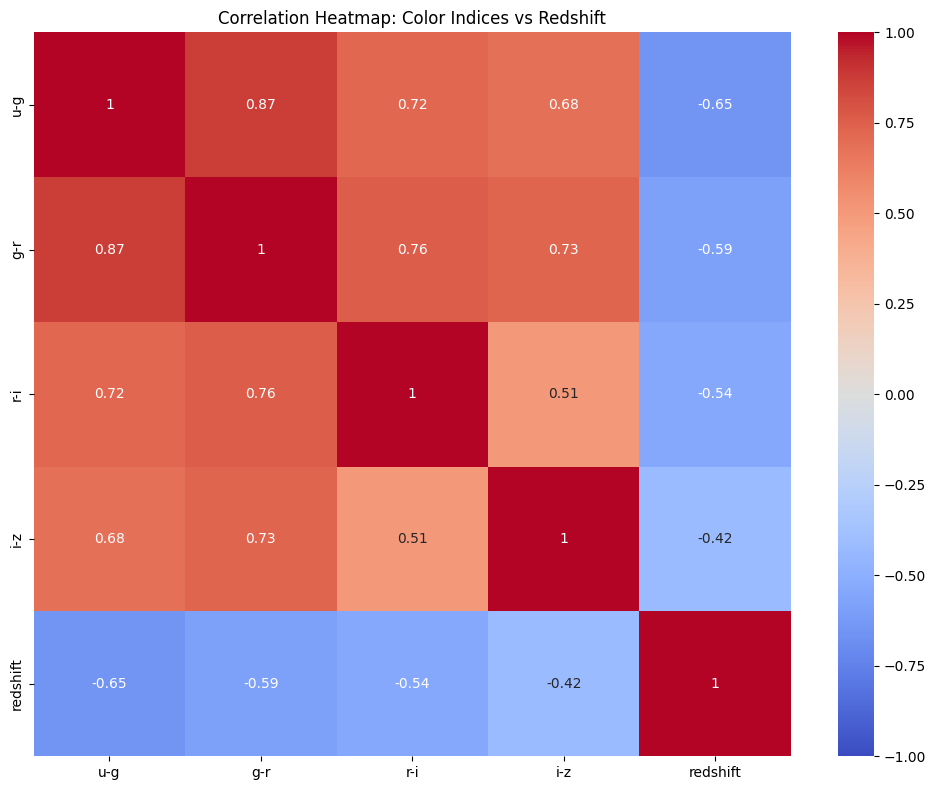

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(sdss.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap: Color Indices vs Redshift')
plt.tight_layout()
plt.show()

#This heatmap visualizes correlations between color indices and redshift.
#It helps identify the most predictive features and potential multicollinearity issues.


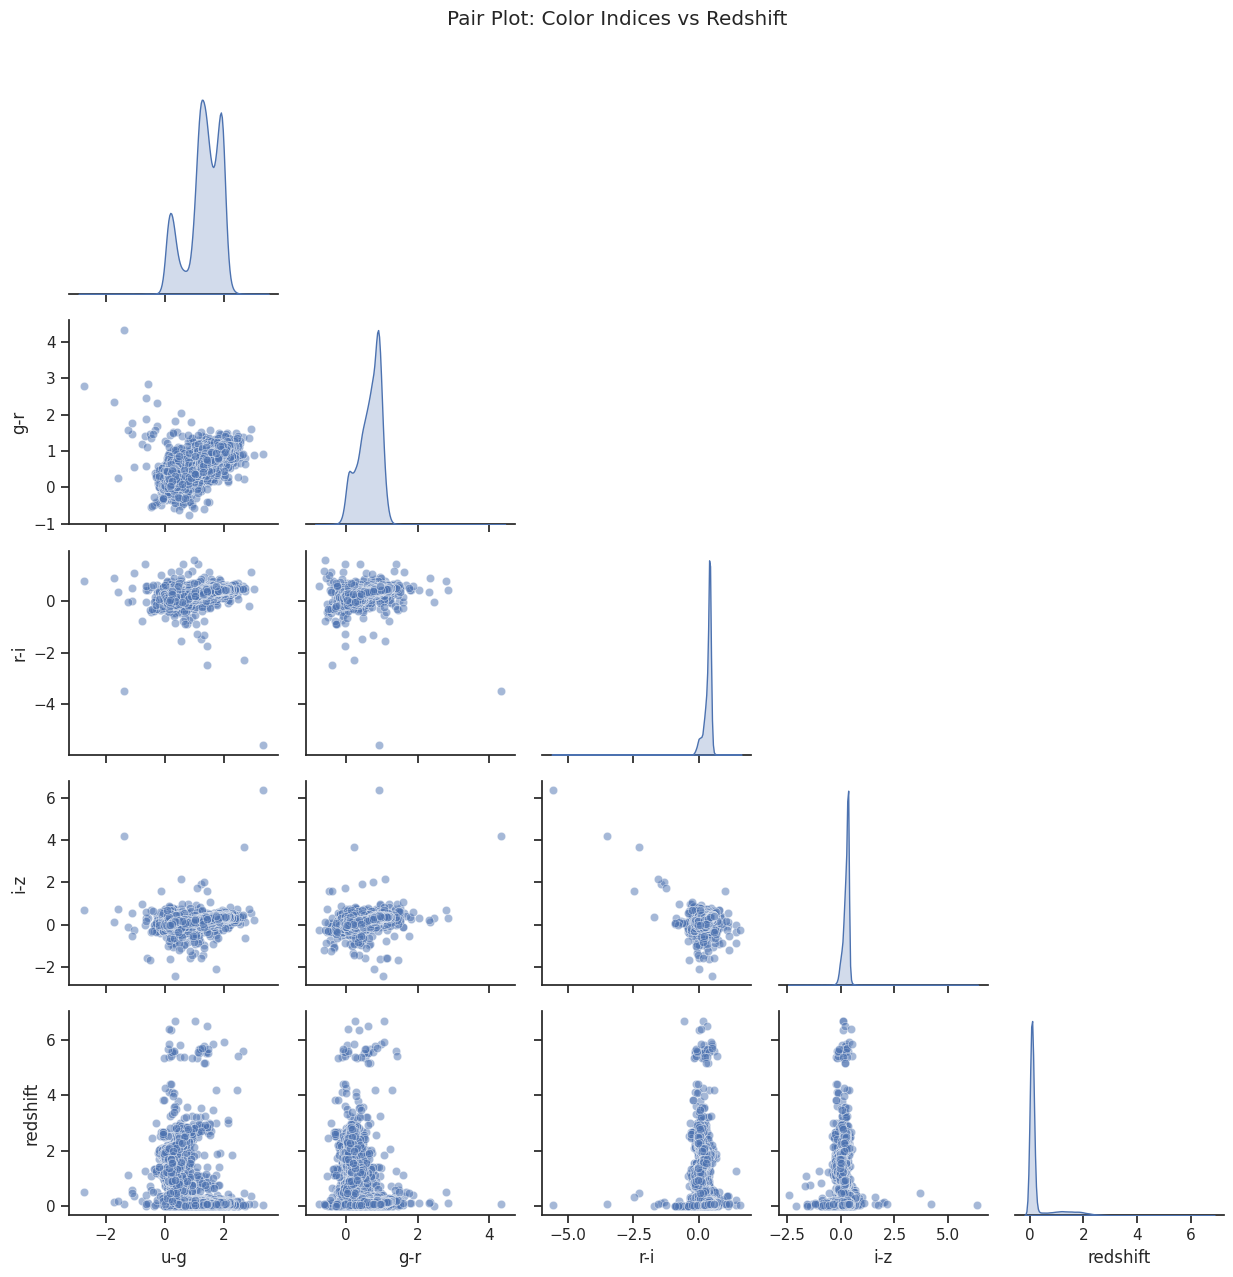

In [ ]:
sns.set(style="ticks")
sns.pairplot(sdss, diag_kind='kde', corner=True, plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot: Color Indices vs Redshift', y=1.02)
plt.tight_layout()
plt.show()

#This pair plot reveals distributions and pairwise relationships between color indices and redshift.
#It helps identify non-linear patterns and outliers, guiding my modeling approach.


In [ ]:
X_sdss = sdss[['u-g', 'g-r', 'r-i', 'i-z']]
y_redshift = sdss['redshift']

# 60 - 20 - 20 split
X_train, X_temp, y_train, y_temp = train_test_split(X_sdss, y_redshift, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#implementing a ridge regression by just using math
#Helper functions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)


def train_ridge(X_train, y_train, lam, learning_rate, epochs):
    n, d = X_train.shape
    w = np.zeros(d)
    b = 0

    for epoch in range(epochs):
        # Make predictions
        y_pred = X_train @ w + b

        # Calculate loss
        loss = mean_squared_error(y_train, y_pred) + lam * np.sum(w ** 2)

        # Calculate gradients
        dw = (2/n) * X_train.T @ (y_pred - y_train) + 2 * lam * w
        db = (2/n) * np.sum(y_pred - y_train)

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

    return w, b

In [ ]:
lambdas = [0.001, 0.01, 0.1]
learning_rates = [0.001, 0.01, 0.1]
epochs = 1000

In [ ]:
best_mse = float('inf')
best_params = None
best_w = None
best_b = None

In [ ]:
# Grid search
for lam in lambdas:
    for lr in learning_rates:
        w, b = train_ridge(X_train_scaled, y_train, lam, lr, epochs)

        # Evaluate on validation set
        y_val_pred = X_val_scaled @ w + b
        val_mse = mean_squared_error(y_val, y_val_pred)

        print(f"Lambda: {lam}, Learning Rate: {lr}, Validation MSE: {val_mse}")

        if val_mse < best_mse:
            best_mse = val_mse
            best_params = (lam, lr)
            best_w = w
            best_b = b

print(f"\nBest parameters - Lambda: {best_params[0]}, Learning Rate: {best_params[1]}")
print(f"Best Validation MSE: {best_mse}")

Lambda: 0.001, Learning Rate: 0.001, Validation MSE: 0.167523838327109
Lambda: 0.001, Learning Rate: 0.01, Validation MSE: 0.1600703508598641
Lambda: 0.001, Learning Rate: 0.1, Validation MSE: 0.16003666630358107
Lambda: 0.01, Learning Rate: 0.001, Validation MSE: 0.1675725652195938
Lambda: 0.01, Learning Rate: 0.01, Validation MSE: 0.16016736091977885
Lambda: 0.01, Learning Rate: 0.1, Validation MSE: 0.16010548047444023
Lambda: 0.1, Learning Rate: 0.001, Validation MSE: 0.1681385753444587
Lambda: 0.1, Learning Rate: 0.01, Validation MSE: 0.16193818696360285
Lambda: 0.1, Learning Rate: 0.1, Validation MSE: 0.1619111650597002

Best parameters - Lambda: 0.001, Learning Rate: 0.1
Best Validation MSE: 0.16003666630358107


In [ ]:
y_pred_test = X_test_scaled @ w + b
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Test MSE: {test_mse}")

r2 = r_squared(y_test, y_pred_test)
print(f"R-squared score: {r2}")

Test MSE: 0.1573243063420623
R-squared score: 0.4434803521046953


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sdss, y_redshift, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get best model
best_xgb_model = grid_search.best_estimator_

In [ ]:
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate MSE and R-squared
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r_squared(y_test, y_pred_xgb)

print(f"Best parameters: {grid_search.best_params_}")
print(f"MSE: {mse_xgb}")
print(f"R-squared: {r2_xgb}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
MSE: 0.05863073124544724
R-squared: 0.7972780297822692


In [ ]:
# Compare with Ridge Regression results
results = pd.DataFrame({
    'Metric': ['MSE', 'R-squared'],
    'XGBoost': [mse_xgb, r2_xgb],
    'Ridge': [test_mse, r2]
})

print(results.to_string(index=False))

   Metric  XGBoost    Ridge
      MSE 0.058631 0.157324
R-squared 0.797278 0.443480


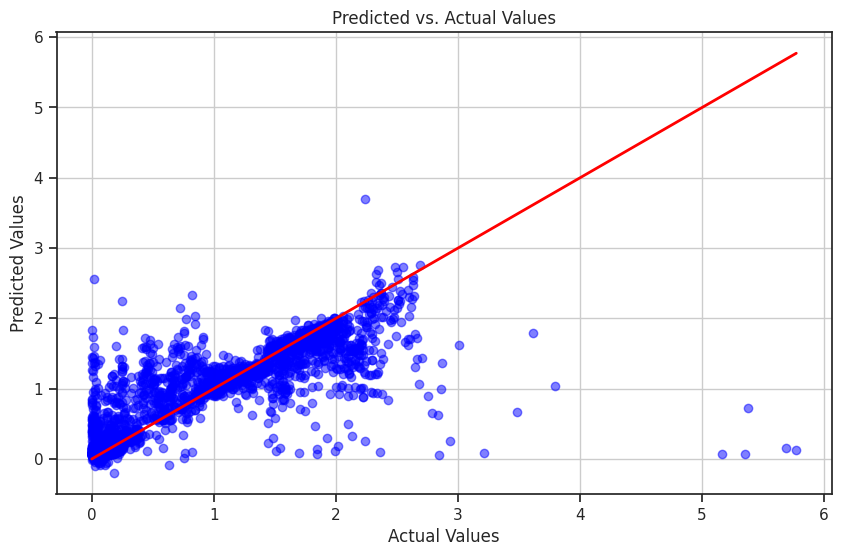

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.grid(True)
plt.show()

Feature Importance:
u-g: 0.7402997016906738
r-i: 0.09185034781694412
g-r: 0.08652185648679733
i-z: 0.08132801204919815


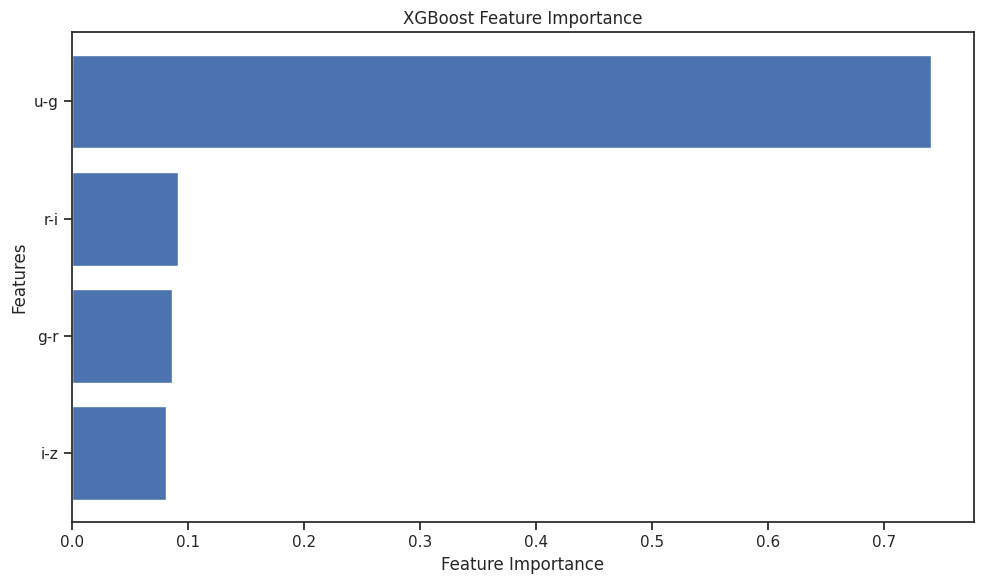

In [ ]:
# Feature importance
feature_importance = best_xgb_model.feature_importances_
feature_names = X_sdss.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

print("Feature Importance:")
for feature, importance in zip(sorted_features, feature_importance[sorted_idx]):
    print(f"{feature}: {importance}")

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
#dump(best_xgb_model, '/content/drive/MyDrive/Coding/astronomy_ML/redshift_model.joblib')